In [1]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os

print(f"tensorflow: {tf.__version__}")
print(f"keras: {tf.keras.__version__}")

tensorflow: 2.0.0-beta1
keras: 2.2.4-tf


In [3]:
data_dir = "data/GSE92742_Broad_LINCS"
out_dir = "data/output"

fnames = [
    "Level3_INF_mlr12k_n1319138x12328.gctx",
    "gene_info.txt",
    "inst_info.txt",
    "pert_info.txt",
    "cell_info.txt",
]

fpaths = {
    "_".join(f.split(".")[0].split('_')[:2]): f"{data_dir}/{f}" for f in fnames
}

### Step 1: Load data and extract untreated samples for DE analysis
#### Load data
Extract all samples for training model (VCAP, MCF7, PC3), but filter for untreated and save for DE analysis in R.

In [4]:
from lib.utils import load_data

pert_types = [
    "trt_cp",  # treated with compound
    "ctl_vehicle",  # control for compound treatment (e.g DMSO)
    "ctl_untrt",  # untreated samples
]

cell_ids = ["VCAP", "MCF7", "PC3"]  # prostate tumor  # breast tumor  # prostate tumor

# Load Data
dset = load_data(
    fpaths["Level3_INF"], fpaths["inst_info"], fpaths["gene_info"], pert_types, cell_ids
)

dset

<LINCS Dataset: (samples: 333,523, genes: 978)>

#### Sample controls and save to disk 
Extract the control samples for DE.

In [5]:
ctrl_data = dset.filter_rows(pert_type=["ctl_vehicle", "ctl_untrt"])
ctrl_data.sample_rows(meta_groups="cell_id", size=100).to_tsv(out_dir, name='control')

#### Create model


In [6]:
from lib.models import create_AE

tf.random.set_seed(42)
np.random.seed(42)

dset.normalize_by_gene()
dset.train_val_test_split()

print(f"training size:   {dset.train}")
print(f"validation size: {dset.val}")
print(f"testing size:    {dset.test}")

training size:   <LINCS Dataset: (samples: 213,454, genes: 978)>
validation size: <LINCS Dataset: (samples: 53,364, genes: 978)>
testing size:    <LINCS Dataset: (samples: 66,705, genes: 978)>


In [7]:
h_size = 32
model = create_AE([128, h_size, 128], dropout=0.15)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 978)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               125312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0

#### Train Model

In [8]:
batch_size = 64
model.fit(
    dset.train.to_tf_dataset(target="self", batch_size=batch_size),
    epochs=10,
    shuffle=True,
    steps_per_epoch=dset.train.data.shape[0] // batch_size,
    validation_data=(dset.val.data.values, dset.val.data.values),
#     verbose=False,
)

W0715 10:34:47.590052 139817068140352 deprecation.py:323] From /Users/manz01/miniconda3/envs/lincs-gpu/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
3335/3335 [==============================] - 17s 5ms/step - loss: 0.0092 - cosine_similarity: 0.9883 - pearsons_corrcoef: 0.8592 - val_loss: 0.0062 - val_cosine_similarity: 0.9919 - val_pearsons_corrcoef: 0.8896
Epoch 2/10
3335/3335 [==============================] - 15s 4ms/step - loss: 0.0060 - cosine_similarity: 0.9921 - pearsons_corrcoef: 0.8866 - val_loss: 0.0049 - val_cosine_similarity: 0.9935 - val_pearsons_corrcoef: 0.9145
Epoch 3/10
3335/3335 [==============================] - 14s 4ms/step - loss: 0.0052 - cosine_similarity: 0.9930 - pearsons_corrcoef: 0.9104 - val_loss: 0.0049 - val_cosine_similarity: 0.9935 - val_pearsons_corrcoef: 0.9150
Epoch 4/10
3335/3335 [==============================] - 14s 4ms/step - loss: 0.0050 - cosine_similarity: 0.9932 - pearsons_corrcoef: 0.9097 - val_loss: 0.0047 - val_cosine_similarity: 0.9936 - val_pearsons_corrcoef: 0.9183
Epoch 5/10
3335/3335 [==============================] - 14s 4ms/step - loss: 0.0049 - cosine_similarity: 0.9

In [9]:
test_loss = model.evaluate(dset.test.data.values, dset.test.data.values)
print(f"loss: {test_loss}")

66705/66705 [==============================] - 3s 40us/sample - loss: 0.0047 - cosine_similarity: 0.9936 - pearsons_corrcoef: 0.9150
loss: [0.0046902789467423945, 0.99364763, 0.9149876]


#### Examine hidden output for control samples

In [10]:
from lib.utils import get_hidden_activations
# Extract control samples from testing data
test_ctrl_data = dset.test.filter_rows(pert_type=["ctl_vehicle", "ctl_untrt"])

encoder = tf.keras.Model(inputs=model.layers[0].input, outputs=model.layers[3].output)
hidden_output = get_hidden_activations(test_ctrl_data.data, encoder)
hidden_output.head()

,unit_0,unit_1,unit_2,unit_3,unit_4,unit_5,unit_6,unit_7,unit_8,unit_9,...,unit_22,unit_23,unit_24,unit_25,unit_26,unit_27,unit_28,unit_29,unit_30,unit_31
inst_id,,,,,,,,,,,,,,,,,,,,,
KDB002_MCF7_96H_X3_B1_DUO53HI52LO:F16,0.000000,0.304981,0.000000,0.0,0.000000,0.000000,0.0,0.352631,0.000000,0.0,...,0.102432,0.076534,0.000000,0.339937,0.0,0.000000,0.000000,0.0,0.000000,0.000000
DOS032_MCF7_24H_X1_F2B4_DUO52HI53LO:F10,0.703499,0.000000,0.000000,0.0,0.000000,0.534186,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.227705,0.262818,0.0,0.000000,0.000000,0.0,0.494101,0.000000
ERGK006_VCAP_120H_X3_B2_DUO52HI53LO:G20,0.000000,0.000000,0.000000,0.0,0.224437,0.000000,0.0,0.323905,0.106188,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.078065,0.000000,0.0,0.000000,0.000000
CPD002_MCF7_6H_X3_B6_DUO52HI53LO:F05,0.174206,0.000000,0.270765,0.0,0.000000,0.237626,0.0,0.000000,0.000000,0.0,...,0.127958,0.000000,0.512534,0.320742,0.0,0.000000,0.018362,0.0,0.000000,0.000000
KDA009_MCF7_96H_X2_B1_DUO45HI44LO:N13,0.000000,0.657104,0.000000,0.0,0.120015,0.000000,0.0,0.447732,0.000000,0.0,...,0.541010,0.503144,0.000000,0.490663,0.0,0.101605,0.000000,0.0,0.000000,0.462733


### Zero-out method

In [11]:
import altair as alt
from lib.hidden_embedding import HiddenEmbedding

# Initialize hidden embedding class
he = HiddenEmbedding(test_ctrl_data, encoder)

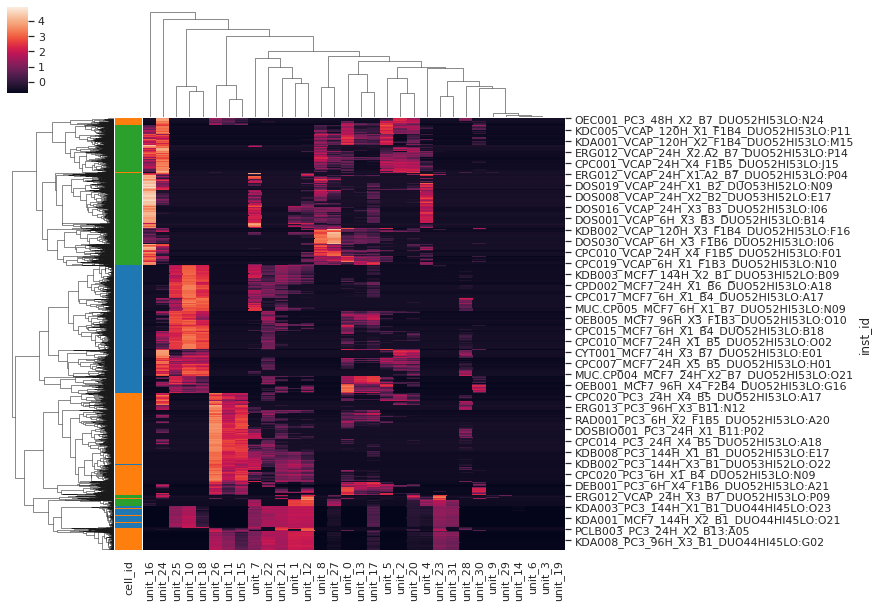

In [12]:
# Examine hidden activations 
he.plot_clustermap()

/Users/manz01/miniconda3/envs/lincs-gpu/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


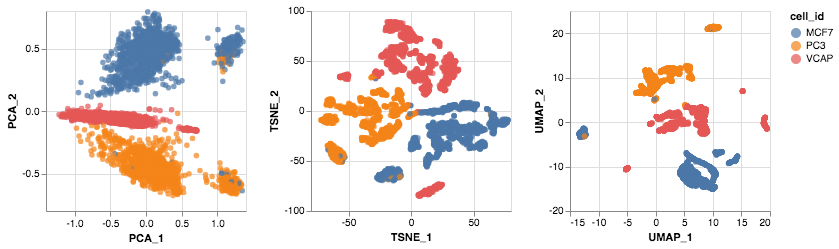

In [13]:
# compare with embedding projections
embedding_plots = [he.plot_embedding(e).properties(width=200, height=200) for e in ["PCA", "TSNE", "UMAP"]]
alt.hconcat(*embedding_plots)

In [14]:
# Zero out each gene for each sample and examine difference in hidden output
he.zero_out_genes()

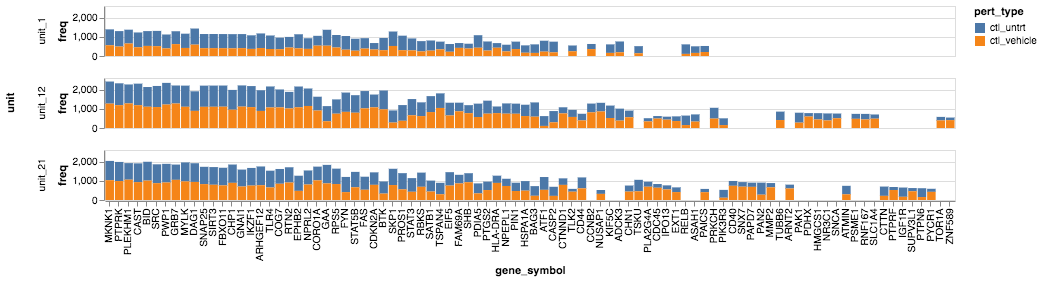

In [15]:
he.plot_unit_counts("pert_type", units=[24], count_thresh=500, k_max=50)

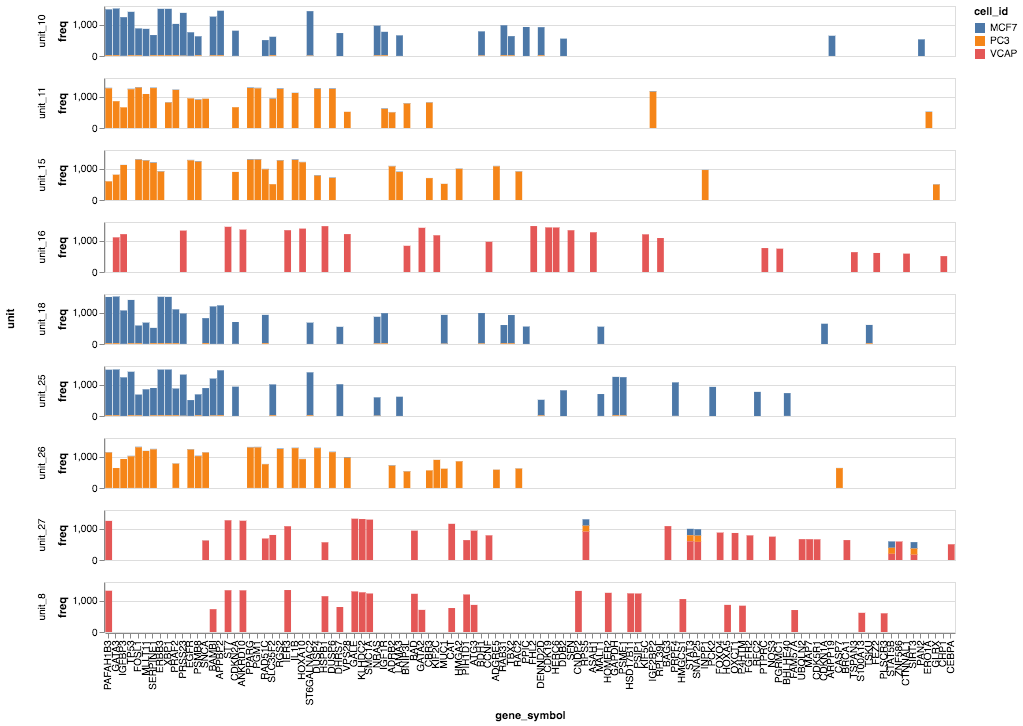

In [22]:
selected_units = [16,8,27,25,10,18,26,11,15] # selected units from clustermap
he.plot_unit_counts("cell_id", units=selected_units, count_thresh=500, k_max=25)

In [23]:
genes_by_unit = he.get_genes_by_unit("cell_id", units=selected_units, count_thresh=500, k_max=25)

#### Gene set analysis

In [18]:
from lib.enrichr import EnrichrQuery

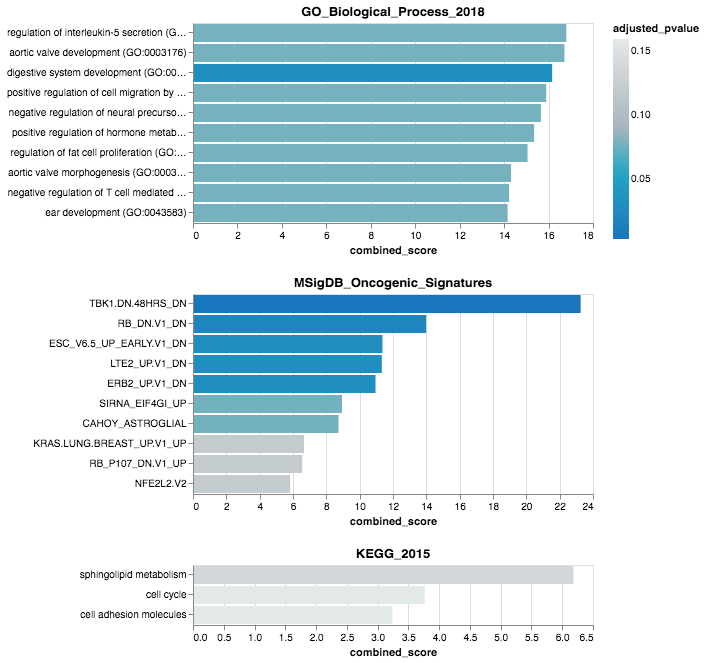

In [24]:
gene_list = genes_by_unit['unit_16']['VCAP']
description = "Genes activating unit 16 the most."
enr = EnrichrQuery(
    gene_list,
    description,
    library="OxEnrichr" # Enrichr is down
)
enr.enrich(["GO_Biological_Process_2018", "MSigDB_Oncogenic_Signatures", "KEGG_2015"])
enr.plot(size=10, pvalue_thresh=0.2)

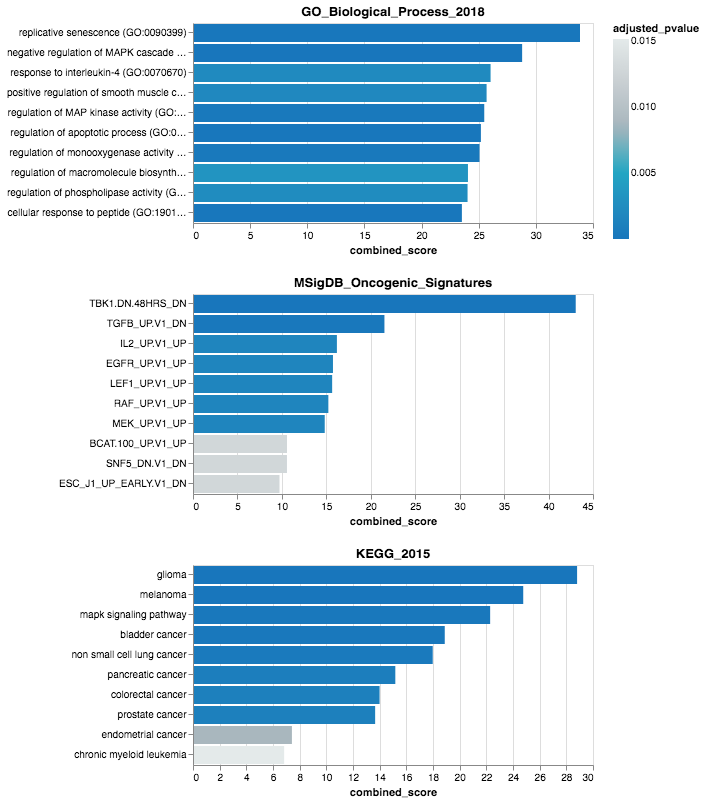

In [25]:
gene_list = genes_by_unit['unit_11']['PC3']
description = "Genes activating unit 11 the most PC3."
enr = EnrichrQuery(
    gene_list,
    description,
    library="OxEnrichr" # Enrichr is down
)
enr.enrich(["GO_Biological_Process_2018", "MSigDB_Oncogenic_Signatures", "KEGG_2015"])
enr.plot(size=10, pvalue_thresh=0.2)

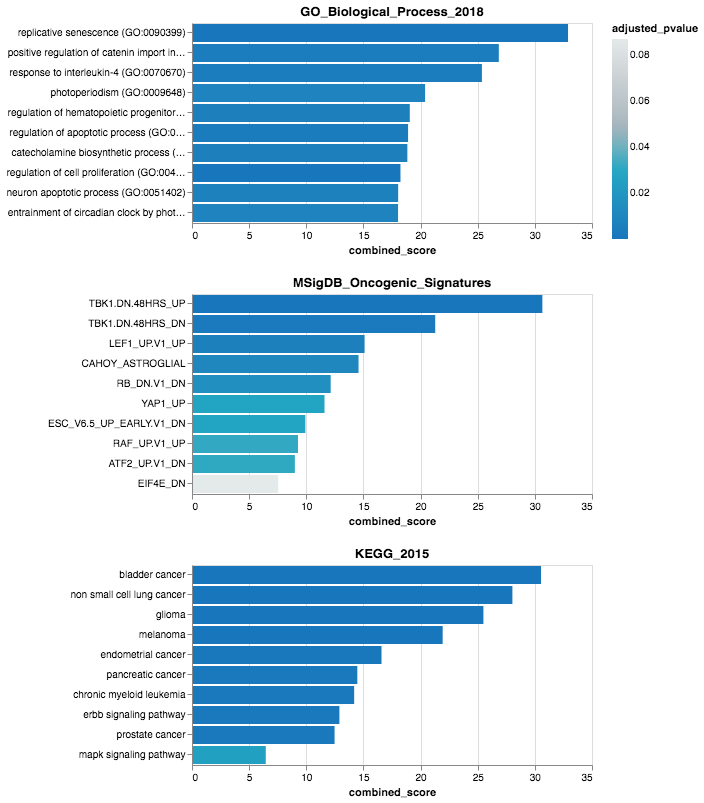

In [26]:
gene_list = genes_by_unit['unit_25']['MCF7']
description = "Genes activating unit 25 the most."
enr = EnrichrQuery(
    gene_list,
    description,
    library="OxEnrichr" # Enrichr is down
)
enr.enrich(["GO_Biological_Process_2018", "MSigDB_Oncogenic_Signatures", "KEGG_2015"])
enr.plot(size=10, pvalue_thresh=0.2)